![logo](./figures/LogoLine_horizon_C3S.png)

# Global Warming Levels 

Time periods for which +1.5, +2, +3 and +4 degree Transient Global Warming Levels (GWLs)  are reached, relative the pre-industrial 1850-1900 mean value, are precomputed in the C3S Atlas for CMIP5 and CMIP6 using a 20-year moving window, building on the datasets available in the [C3S Climate Data Store](https://cds.climate.copernicus.eu/). 

The approach is similar to that described by, e.g., [Nikulin et al. (2018)](https://iopscience.iop.org/article/10.1088/1748-9326/aab1b1) and [Diez-Sierra et al. (2023)](https://link.springer.com/article/10.1007/s00382-023-06790-y). The values provided in the GWL tables in this directory [CMIP5 Warming Levels](https://github.com/ecmwf-projects/c3s-atlas/blob/main/auxiliar/GWLs/CMIP5_WarmingLevels_plusIPCC-Atlas.csv) and [CMIP6 Warming Levels](https://github.com/ecmwf-projects/c3s-atlas/blob/main/auxiliar/GWLs/CMIP6_WarmingLevels.csv) correspond to the 20-year window where the warming is first reached (the GWL period is thus calculated as [n, n+19]). Cells with 'NA' indicate that the GWL was not reached before (the initial year) 2100. Cells with '9999' correspond to models with no available data for the particular scenario. 

This notebook is a collection of recipes for calculating the GWL tables used in the ["C3S Atlas"](https://atlas.climate.copernicus.eu/atlas). For quick demonstration purposes, GWLs are calculated for a single member of CMIP6.

**<span style="color:red">Please be advised that downloading the required data for this script may take several minutes.</span>**

### Load Python packages and clone and install the c3s-atlas GitHub repository from the ecmwf-projects

Clone (`git clone`) the [C3S-atlas](https://github.com/ecmwf-projects/c3s-atlas) repository and install them (`pip install -e .`).

Further details on how to clone and install the repository are available in the [requirements](https://github.com/ecmwf-projects/c3s-atlas?tab=readme-ov-file#requirements)

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import glob
from pathlib import Path
import cdsapi

from c3s_atlas.utils import (
    extract_zip_and_delete,
)

### Define some specific functions

In [2]:
## Unitary test for the rolling mean function implemented in xarray
da = xr.DataArray(
    np.linspace(0, 11, num=12),
    coords=[
        pd.date_range("1999-12-15",periods=12, freq=pd.DateOffset(months=1),)
    ],
    dims="time",
)
da_rolling = da.rolling(time=3, center=False, min_periods=1).mean()
msg = "The definition of the rolling window boundaries implemented in xarray have changed"
assert da_rolling[-1].data == 10, msg

In [3]:
def GSAT(ds: xr.Dataset) -> xr.Dataset:
    """
    Calculate GSAT (Global‐mean Surface Air Temperature)
    
    Parameters
    ----------
    ds : xr.Dataset
    
    Returns
    -------
    ds : xr.Dataset
    """
    # Temporal aggregation
    ds = ds.resample(time="YE").mean(skipna = True)
    # Spatial aggregation
    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"
    tas_weighted_mean = ds.weighted(weights).mean(dim = ["lat"], skipna = True)
    tas_weighted_mean = tas_weighted_mean.mean(dim = ["lon"], skipna = True)
    return tas_weighted_mean

### Download climate data with the CDS API
To reduce data size and download time, a geographical subset focusing on a apecific area within the European region (Spain) is selected.

- Catalogue: [CMIP6 climate projections](https://cds.climate.copernicus.eu/datasets/projections-cmip6?tab=overview)
- [How to use the CDS API](https://cds.climate.copernicus.eu/how-to-api)

In [4]:
# define some global attributes for the CDS-API
CMIP6_years = {
    "historical": [str(n) for n in np.arange(1850, 2014)],
    "ssp5_8_5": [str(n) for n in np.arange(2014, 2101)]
}
variable = "tas"
simulation = "cmcc_esm2"
project = 'CMIP6'
file_dest_CMIP6 = Path('./data/CMIP6')

In [5]:
months = [
    '01', '02', '03',
    '04', '05', '06',
    '07', '08', '09',
    '10', '11', '12'
]

In [ ]:
c = cdsapi.Client()

In [ ]:
os.makedirs(file_dest_CMIP6, exist_ok=True)

for experiment in CMIP6_years.keys():
    for year in CMIP6_years[experiment]:
        path_zip = file_dest_CMIP6 / f"CMIP6_{variable}_{experiment}_mon_{year}.zip"
        c.retrieve(
            'projections-cmip6',
            {
                'format': 'zip',
                'temporal_resolution': 'monthly',
                'variable': "near_surface_air_temperature",
                'experiment': experiment,
                'model': simulation,
                'year': [year],
                'month': months,
            },
            path_zip)
        # Extract zip file into the specified directory and remove zip
        extract_zip_and_delete(path_zip) 

### Define inputs

In [10]:
GWLs = ['1.5', '2', '3', '4']
PI_period = slice('1850', '1900')
window_width = 20
project = 'CMIP6'
experiment = 'ssp585'

### Load files with xarray
- https://docs.xarray.dev/en/stable/

In [11]:
# load CMIP6 files
ds_hist = xr.open_mfdataset(
    np.sort(glob.glob(str(file_dest_CMIP6 / "CMIP6_tas_historical_mon_*.nc"))), 
    concat_dim='time', combine='nested'
)
ds_sce = xr.open_mfdataset(
    np.sort(glob.glob(str(file_dest_CMIP6 / "CMIP6_tas_ssp5_8_5_mon_*.nc"))), 
    concat_dim='time', combine='nested'
)

### Calculate GWL periods

##### Create empty dataframe to save the results

In [12]:
# create a empty dataframe to store the results
columns = pd.MultiIndex.from_tuples([(GWL, experiment) for GWL in GWLs])
df_GWLs = pd.DataFrame('9999', index = [simulation], columns = columns)
# create dataframe to store the rolling mean series
columns = pd.MultiIndex.from_tuples([(experiment, simulation)])
df_GWLs_serie = pd.DataFrame(index = pd.date_range(start = '1850', end = '2101', freq = 'YE'), columns = columns)

##### Calculate GSAT (Global Surface Average Temperature)

In [13]:
ds_hist_sce = xr.concat([ds_hist, ds_sce], dim = 'time')
ds_hist_sce['tas'] = ds_hist_sce['tas'] - 273.15 # kelvin to degree C
ds_hist_sce_GSAT = GSAT(ds_hist_sce)

In [14]:
# Calculate Preindustrial GSAT 
ds_PI_GSAT = ds_hist_sce_GSAT.sel(time = PI_period)
ds_PI_GAST_mean = ds_PI_GSAT[variable].mean()

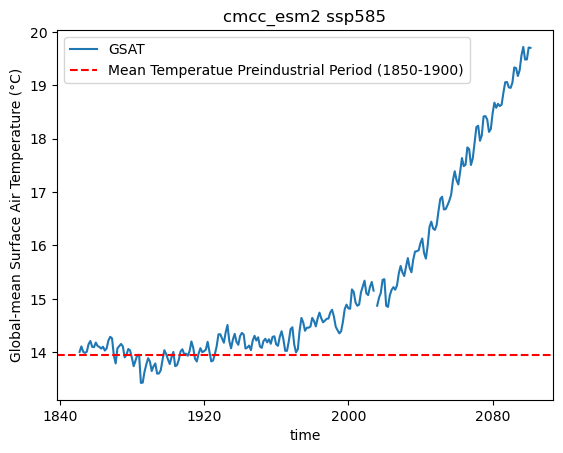

In [15]:
ds_hist_sce_GSAT[variable].plot(label='GSAT')
plt.axhline(y=ds_PI_GAST_mean, color='r', linestyle='--', 
            label='Mean Temperatue Preindustrial Period (1850-1900)')
plt.ylabel('Global‐mean Surface Air Temperature (°C)')
plt.legend()
plt.title(f"{simulation} ssp585")
plt.show()

#### Calculate GWLs

In [16]:
ds_hist_sce_GSAT_rolling = ds_hist_sce_GSAT.rolling(time = window_width, min_periods=1, center = False).mean() # [n - window + 1, n]
GWLs_tas = (ds_hist_sce_GSAT_rolling - ds_PI_GAST_mean)
# Store delta change series with respect 1850-1900
df_GWLs_serie[(experiment, simulation)] = (ds_hist_sce_GSAT_rolling[variable].to_dataframe()[variable] - ds_PI_GAST_mean.data).values

In [ ]:
for GWL in GWLs:
    GWLs_time = GWLs_tas['time'].where(GWLs_tas[variable] > float(GWL)).dropna(dim = "time")
    if len(GWLs_time) == 0:
        df_GWLs.loc[simulation][(GWL, experiment)] = 'NA'
    else:
        window_left = GWLs_time[0]['time'].dt.year.data - (window_width - 1)
        window_right = GWLs_time[0]['time'].dt.year.data
        df_GWLs.loc[simulation][(GWL, experiment)] = str(int(window_left)) + '-' + str(int(window_right))

In [26]:
df_GWLs

,1.5,2,3,4
,ssp585,ssp585,ssp585,ssp585
cmcc_esm2,2020-2039,2030-2049,2046-2065,2061-2080


The above dataframe shows the period in which the CMCC-ESM2 model reaches different GWLs (1.5, 2, 3, and 4°C) relative to the pre-industrial period. These periods are used in the C3S Atlas to produce the different products involving GWLs.

### Plotting example: GWL +2 degC (ssp585)

In [19]:
GWL = '2'
df_GWLs_serie_sce = df_GWLs_serie[(experiment)]
df_GWLs_serie_sce = df_GWLs_serie_sce.dropna(axis = 1, how = 'all')

In [ ]:
time_GWL = df_GWLs[(GWL, experiment)]
time_GWL = time_GWL[pd.notnull(time_GWL)]
time_GWL = time_GWL[time_GWL!='9999']
time_GWL_time = pd.DataFrame(index = time_GWL.index)
time_GWL_time['year_left'] = [pd.to_datetime(str(period.split('-')[0])+'-12-31', infer_datetime_format=True) 
                         for period in time_GWL.values]
time_GWL_time['year_right'] = [pd.to_datetime(str(period.split('-')[1])+'-12-31', infer_datetime_format=True) 
                         for period in time_GWL.values]

In [21]:
xticks = pd.to_datetime(["1850-12-31", "1900-12-31", "1950-12-31", "2000-12-31","2050-12-31", "2100-12-31"])
color = cm.rainbow(np.linspace(0, 1, np.shape(df_GWLs_serie_sce)[1]))

Text(0.5, 1.0, '20 - year window width')

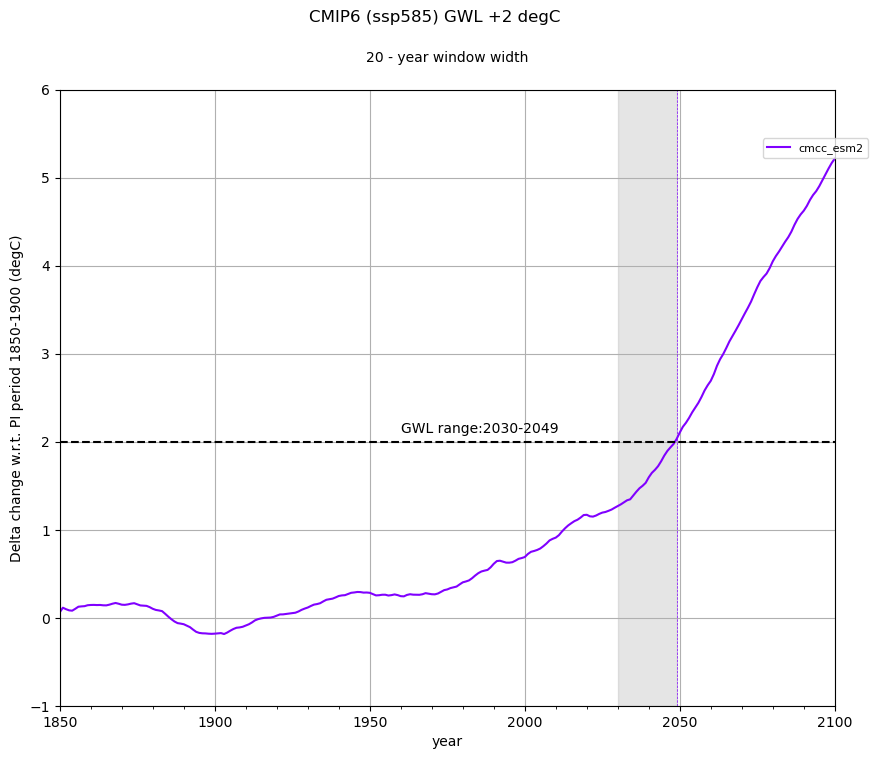

In [22]:
fig, ax = plt.subplots(figsize = (10, 8))
df_GWLs_serie_sce.plot(ax = ax, color = color)
ax.axhline(y = int(GWL), color='k', linestyle = '--')
for n, sim in enumerate(time_GWL_time.index):
    ax.axvline(x = time_GWL_time['year_right'].loc[sim], color = color[n], linestyle='--', 
               linewidth = 0.5, alpha = 1)
    ax.fill_between(x = [time_GWL_time['year_left'].loc[sim], time_GWL_time['year_right'].loc[sim]], 
                    y1 = -1, y2 = 6, color = 'grey', alpha = 0.2)
ax.legend(bbox_to_anchor = (1.05, 0.93), fontsize = 8)
ax.grid(True)
ax.set_ylabel("Delta change w.r.t. PI period 1850-1900 (degC)")
ax.set_xlabel("year")
ax.annotate('GWL range:' + str(np.min([int(period.split('-')[0]) for period in time_GWL.values])) 
                   + '-' + str(np.max([int(period.split('-')[1]) for period in time_GWL.values])), xy = (-10,int(GWL)+0.1))
ax.set_xticks(xticks)
ax.set_xticklabels([y.year for y in xticks])
ax.set_ylim([-1, 6])
plt.suptitle(f"CMIP6 ({experiment}) GWL +2 degC")
plt.title("20 - year window width", fontsize = 10, pad = 20)